In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pywt
import keras
from statsmodels.graphics.tsaplots import plot_acf
from sktime.transformations.series.outlier_detection import HampelFilter

# Prep Work

In [2]:
def load_and_concat_data(file_paths, column_names):
    """
    Load and concatenate data from multiple CSV files given by file_paths.

    :param file_paths: List of file paths to the CSV files.
    :param column_names: List of column names for the CSV files.

    :return pd.DataFrame: DataFrame for each feature containing raw data from the years 2023 - 2024.
    """
    df = [pd.read_csv(file_path, header=1, names=column_names) for file_path in file_paths]
    concat_data = pd.concat(df)
    concat_data.reset_index(drop=True, inplace=True)
    concat_data["timestamp"] = pd.to_datetime(concat_data["timestamp"])
    concat_data.set_index("timestamp", inplace=True)
    
    # if na values are present interpolate them based on the timestamp
    if concat_data.isna().sum().sum() > 0:
        concat_data.interpolate(method="time", inplace=True)
    
    return concat_data

### File Paths and Column Names config

In [3]:
file_paths = {
    "de_prices": ["../data/raw/de_prices_2023.csv", "../data/raw/de_prices_2024.csv"],
    "de_load": ["../data/raw/de_load_2023.csv", "../data/raw/de_load_2024.csv"],
    "de_solar_gen": ["../data/raw/de_solar_gen_2023.csv", "../data/raw/de_solar_gen_2024.csv"],
    "de_wind_gen_offshore": ["../data/raw/de_wind_gen_offshore_2023.csv", "../data/raw/de_wind_gen_offshore_2024.csv"],
    "de_wind_gen_onshore": ["../data/raw/de_wind_gen_onshore_2023.csv", "../data/raw/de_wind_gen_onshore_2024.csv"],
    "ch_load": ["../data/raw/ch_load_2023.csv", "../data/raw/ch_load_2024.csv"],
    "dk_load": ["../data/raw/dk_load_2023.csv", "../data/raw/dk_load_2024.csv"],
    "fr_load": ["../data/raw/fr_load_2023.csv", "../data/raw/fr_load_2024.csv"]
}

column_names = {
    "de_prices": ["timestamp", "de_lu_price"],
    "de_load": ["timestamp", "de_load"],
    "de_solar_gen": ["timestamp", "de_solar_gen"],
    "de_wind_gen_offshore": ["timestamp", "de_wind_gen_offshore"],
    "de_wind_gen_onshore": ["timestamp", "de_wind_gen_onshore"],
    "ch_load": ["timestamp", "ch_load"],
    "dk_load": ["timestamp", "dk_load"],
    "fr_load": ["timestamp", "fr_load"]
}

### Populate new dataframes with raw data from years 2023 and 2024

In [76]:
de_prices = load_and_concat_data(file_paths["de_prices"], column_names["de_prices"])
de_load = load_and_concat_data(file_paths["de_load"], column_names["de_load"])
de_solar_gen = load_and_concat_data(file_paths["de_solar_gen"], column_names["de_solar_gen"])
de_wind_gen_offshore = load_and_concat_data(file_paths["de_wind_gen_offshore"], column_names["de_wind_gen_offshore"])
de_wind_gen_onshore = load_and_concat_data(file_paths["de_wind_gen_onshore"], column_names["de_wind_gen_onshore"])
ch_load = load_and_concat_data(file_paths["ch_load"], column_names["ch_load"])
dk_load = load_and_concat_data(file_paths["dk_load"], column_names["dk_load"])
fr_load = load_and_concat_data(file_paths["fr_load"], column_names["fr_load"])

In [77]:
# sub-sampling the quarter hourly timeseries to hourly. see readme for affected timeseries
de_load = de_load[::4]
de_solar_gen = de_solar_gen[::4]
de_wind_gen_offshore = de_wind_gen_offshore[::4]
de_wind_gen_onshore = de_wind_gen_onshore[::4]

In [78]:
dataframes = [
    de_prices,
    de_load,
    de_solar_gen,
    de_wind_gen_offshore,
    de_wind_gen_onshore,
    ch_load,
    dk_load,
    fr_load
]

combined_df = pd.concat(dataframes, axis=1)

In [38]:
# save dataset to csv in ../data/interim
combined_df.to_csv("../data/interim/combined_data.csv")

# Statisical Analysis

In [79]:
# statistical overview
combined_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
de_lu_price,17544.0,87.364521,57.217911,-500.0,62.8675,88.85,112.500,2325.83
de_load,17544.0,52696.795389,9124.620901,28030.9,45180.1750,52714.90,59755.875,75364.20
de_solar_gen,17544.0,6774.497418,10467.715337,0.8,3.4000,110.10,10672.025,46994.80
de_wind_gen_offshore,17544.0,2801.950838,1861.232107,0.0,1127.7500,2609.55,4326.275,7634.80
de_wind_gen_onshore,17544.0,13175.531766,10290.344627,43.4,4917.2500,10348.15,19263.225,47965.40
ch_load,17544.0,6879.845651,1053.874647,2742.6,6185.0500,6898.40,7588.725,10437.10
dk_load,17544.0,4061.867909,718.324942,2371.2,3526.4750,4047.25,4587.725,9069.60
fr_load,17544.0,48756.730392,9949.586147,28744.0,41534.5000,47265.00,54975.500,82800.00


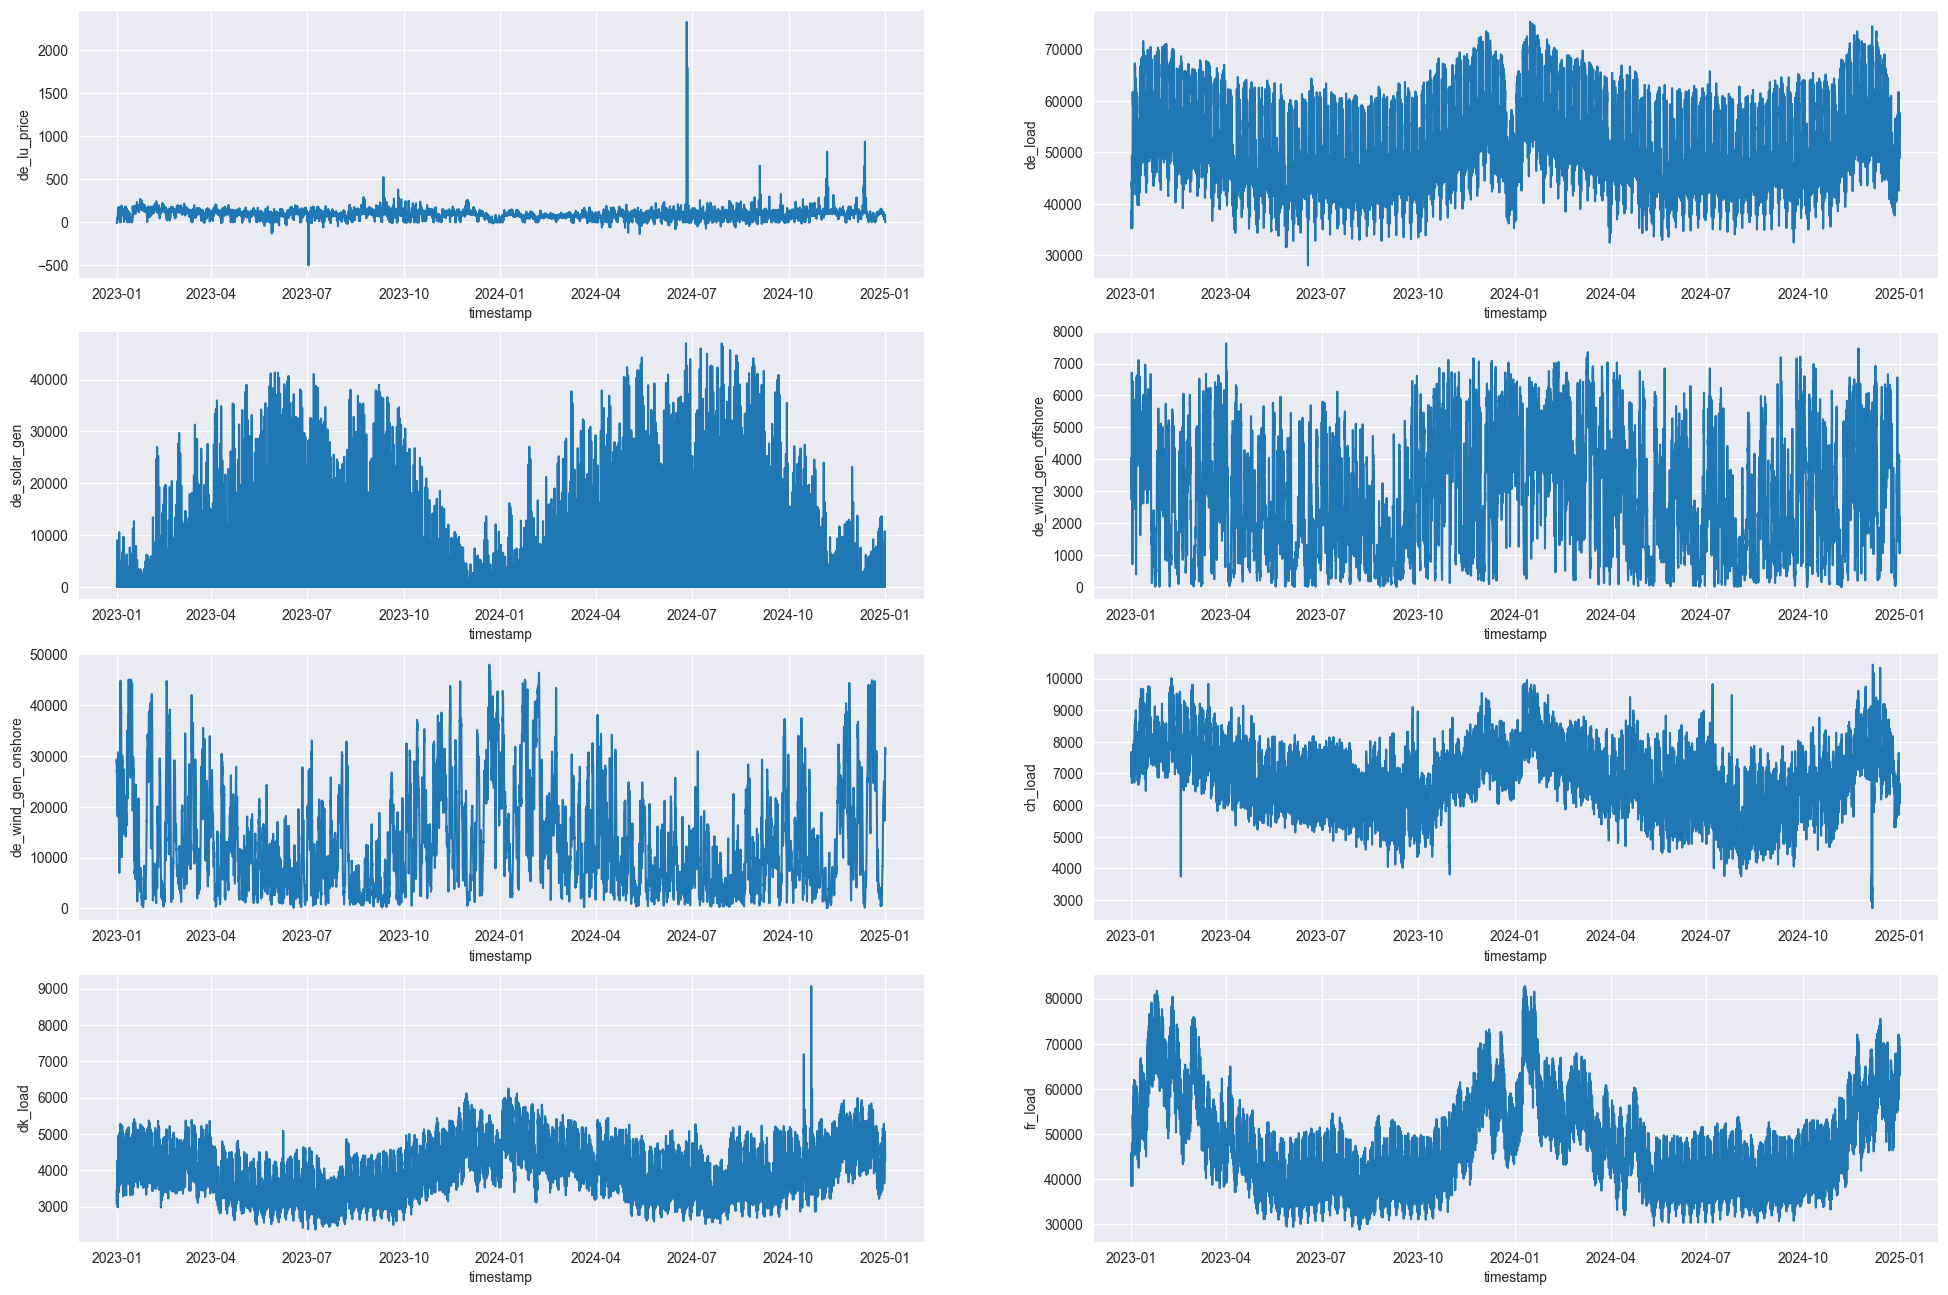

In [40]:
# plot all timeseries for visual inspection
plt.figure(figsize=(24, 16))

for _ in combined_df.columns:
    plt.subplot(4, 2, list(combined_df.columns).index(_)+1)
    sns.lineplot(data=combined_df[_])
    
plt.savefig("../reports/figures/plot_overview.png", dpi=300)

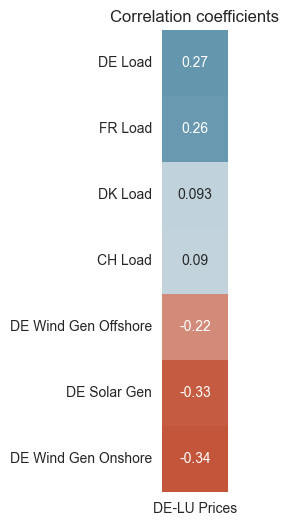

In [41]:
 # get pearson correlation coefficients and plot them
correlation_matrix = combined_df.corr(method="pearson")
correlation_matrix = correlation_matrix.drop(index=["de_lu_price"])
correlation_matrix = correlation_matrix[["de_lu_price"]].sort_values(by="de_lu_price", ascending=False)

cmap = sns.diverging_palette(20, 230, as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            cmap=cmap,
            annot=True,  
            square=True, 
            cbar=False,
            center=0,
            yticklabels=["DE Load", "FR Load", "DK Load", "CH Load", "DE Wind Gen Offshore", "DE Solar Gen", "DE Wind Gen Onshore"],
            xticklabels=["DE-LU Prices"]).set_title("Correlation coefficients")

plt.savefig("../reports/figures/de_lu_price_correlations.png", dpi=300)

plt.show()

### fft and autocorrelation are not suitable because given timeseries is non-stationary

### are they, are they not?

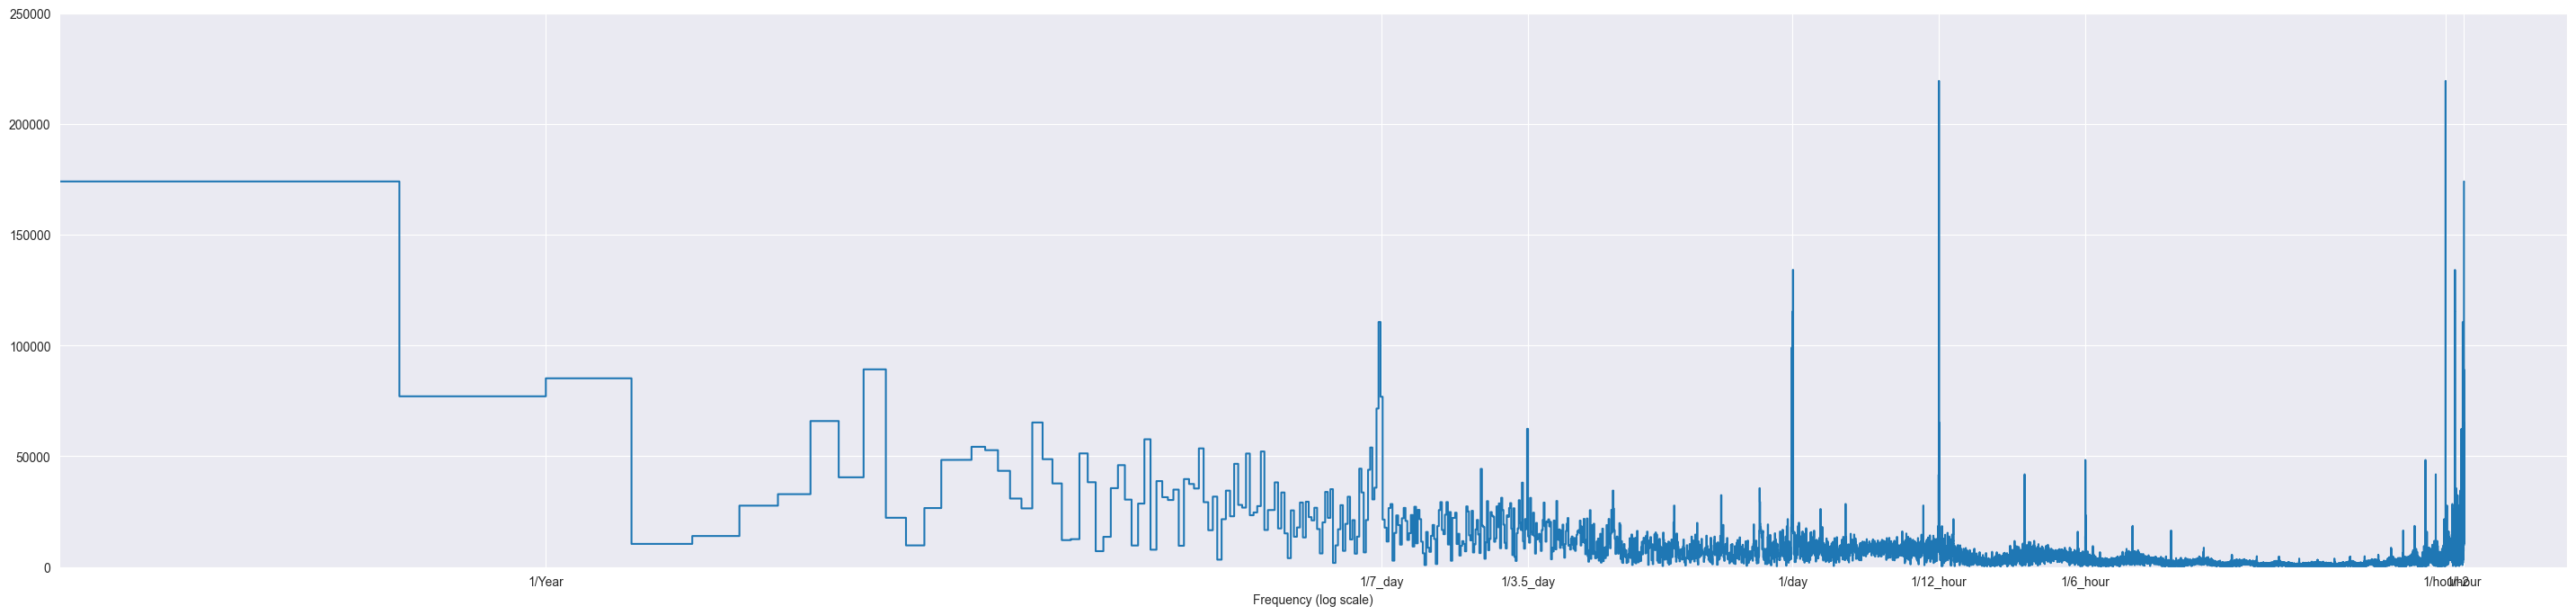

In [42]:
# to check which frequencies are present in the timeseries data fft and wavelet transform are used
fft = tf.signal.fft(combined_df["de_lu_price"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(combined_df["de_lu_price"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h / hours_per_year

plt.figure(figsize=(36, 8))
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 250000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524/7, 365.2524/3.5, 365.2524, 365.2524*2, 365.2524*24/6, 365.2524*22, 365.2524*24], labels=['1/Year', '1/7_day', '1/3.5_day', '1/day', '1/12_hour', '1/6_hour', '1/hour-2', '1/hour'])
_ = plt.xlabel('Frequency (log scale)')

<Figure size 2400x800 with 0 Axes>

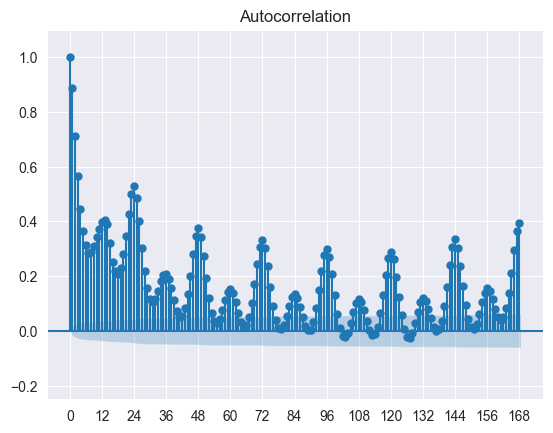

In [43]:
# to further validate time frequencies autocorrelation is measured
plt.figure(figsize=(24, 8))
plot_acf(combined_df["de_lu_price"], lags=7*24)
plt.ylim(-0.25, 1.1)
plt.xticks(np.arange(0, 7*24+1, 12))
plt.show()

### wavelet transform is utilized for non-stationary timeseries data to decompose the signal into different frequencies


In [136]:
# wavelet transform
coefficients = pywt.dwt(combined_df["de_lu_price"], "db5")
coefficients
#plt.imshow(np.abs(coefficients), extent=[0,1,1,100], cmap='PRGn', aspect='auto',
           #vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

(array([-6.48316623, -7.42557957, -1.94831494, ..., 78.9809279 ,
        21.79189349,  2.4485948 ]),
 array([ 0.76820791, -1.16189842,  1.90909175, ..., -3.19762269,
         7.29934142, -2.56950988]))

# Feature Engineering

In [80]:
# create lagged prices according to fft analysis
# 7 day, 1 day, 12 hour and 1 hour lags are introduced
combined_df["de_lu_price_7_day_lag"] = combined_df["de_lu_price"].shift(7*24, fill_value=0)
combined_df["de_lu_price_1_day_lag"] = combined_df["de_lu_price"].shift(24, fill_value=0)
combined_df["de_lu_price_12_hour_lag"] = combined_df["de_lu_price"].shift(12, fill_value=0)
combined_df["de_lu_price_1_hour_lag"] = combined_df["de_lu_price"].shift(1, fill_value=0)
combined_df.head(48)

,de_lu_price,de_load,de_solar_gen,de_wind_gen_offshore,de_wind_gen_onshore,ch_load,dk_load,fr_load,de_lu_price_7_day_lag,de_lu_price_1_day_lag,de_lu_price_12_hour_lag,de_lu_price_1_hour_lag
timestamp,,,,,,,,,,,,
2022-12-31 23:00:00+00:00,-5.17,38691.8,1.6,2737.4,28582.6,7666.8,3440.3,45543.0,0.0,0.00,0.00,0.00
2023-01-01 00:00:00+00:00,-1.07,37733.4,1.0,3142.2,29288.2,7373.0,3388.9,45709.0,0.0,0.00,0.00,-5.17
2023-01-01 01:00:00+00:00,-1.47,37277.4,2.1,4038.7,28916.2,7464.3,3342.5,44640.0,0.0,0.00,0.00,-1.07
2023-01-01 02:00:00+00:00,-5.08,36371.1,1.2,3627.7,27701.4,6896.8,3192.3,41533.0,0.0,0.00,0.00,-1.47
2023-01-01 03:00:00+00:00,-4.49,35625.3,2.1,3286.4,26953.6,7146.0,3107.0,39248.0,0.0,0.00,0.00,-5.08
2023-01-01 04:00:00+00:00,-5.40,35655.0,3.3,3390.5,27321.0,7148.4,3073.4,38389.0,0.0,0.00,0.00,-4.49
2023-01-01 05:00:00+00:00,-5.02,35195.6,1.6,3384.9,26774.0,7148.9,3088.4,38596.0,0.0,0.00,0.00,-5.40
2023-01-01 06:00:00+00:00,-1.30,35834.4,1.2,3574.5,27250.8,7165.6,3117.8,39026.0,0.0,0.00,0.00,-5.02
2023-01-01 07:00:00+00:00,-1.44,36244.5,12.0,3117.5,26810.2,7154.8,3295.2,39316.0,0.0,0.00,0.00,-1.30


In [161]:
features = combined_df.get(
    [
        'de_lu_price',
        'de_lu_price_7_day_lag',
        'de_lu_price_1_day_lag',
        'de_lu_price_12_hour_lag',
        'de_lu_price_1_hour_lag',
        'de_load',
        'de_solar_gen',
        'de_wind_gen_offshore',
        'de_wind_gen_onshore'
     ])

In [159]:
# remove outliers from features using rolling median window
features["de_lu_price"] = HampelFilter(window_length=24, n_sigma=3).fit_transform(features["de_lu_price"])

C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\sktime\transformations\series\outlier_detection.py:103: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


KeyboardInterrupt: 

In [160]:
features

,de_lu_price,de_lu_price_7_day_lag,de_lu_price_1_day_lag,de_lu_price_12_hour_lag,de_lu_price_1_hour_lag,de_load,de_solar_gen,de_wind_gen_offshore,de_wind_gen_onshore
timestamp,,,,,,,,,
2023-01-01 23:00:00+00:00,NaN,0.00,-5.17,-0.79,35.00,37489.8,1.2,3878.1,18411.9
2023-01-02 00:00:00+00:00,NaN,0.00,-1.07,-0.27,57.91,35661.9,1.3,1929.2,18947.4
2023-01-02 01:00:00+00:00,NaN,0.00,-1.47,0.85,51.67,35378.6,2.0,1368.3,20212.1
2023-01-02 02:00:00+00:00,NaN,0.00,-5.08,23.53,52.93,35796.7,1.7,916.9,21872.2
2023-01-02 03:00:00+00:00,NaN,0.00,-4.49,36.54,44.09,36948.8,1.3,705.3,24070.1
...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00+00:00,68.02,108.29,90.21,87.06,74.83,55088.7,8.5,1770.3,24525.6
2024-12-30 21:00:00+00:00,67.26,105.82,83.79,83.71,68.02,53349.1,6.5,2187.0,22236.0
2024-12-30 22:00:00+00:00,35.66,96.99,71.63,78.88,67.26,50345.0,6.2,1417.7,21544.5


# Model Prep

In [146]:
# train validation test splits 70, 20, 10
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
validation_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]

In [147]:
# normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (validation_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

C:\Users\valen\AppData\Local\Temp\ipykernel_16328\2050670021.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(features.keys(), rotation=90)


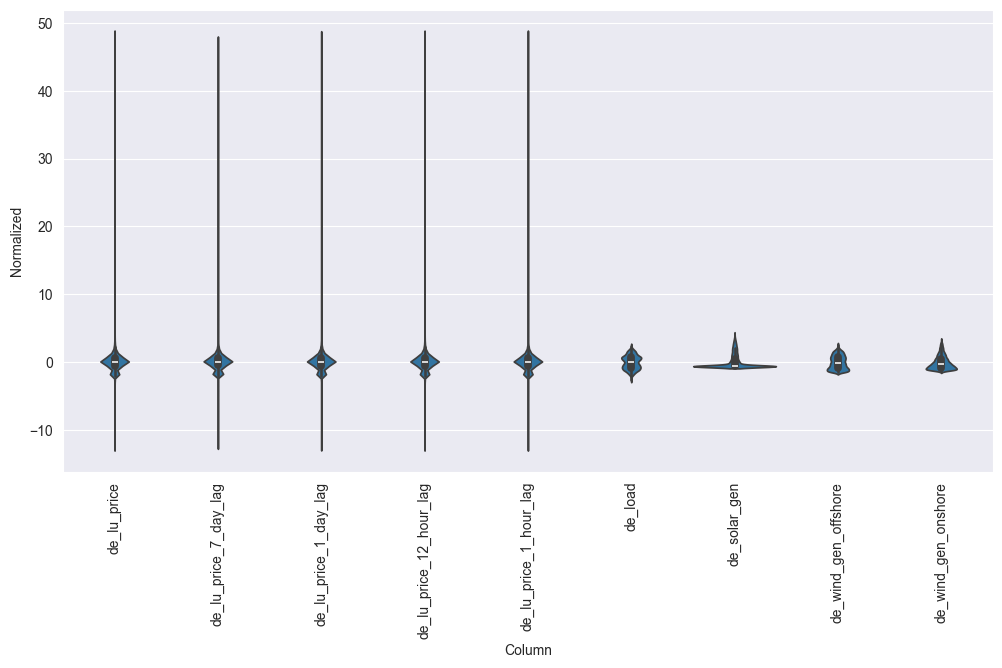

In [148]:
# plot normalized data distribution
df_std = (features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(features.keys(), rotation=90)


In [123]:
# code taken from [3] /references/refs.md
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, validation_df=validation_df, test_df=test_df, 
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.validation_df = validation_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
      inputs = features[:, self.input_slice, :]
      labels = features[:, self.labels_slice, :]
      if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
    
      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
      inputs.set_shape([None, self.input_width, None])
      labels.set_shape([None, self.label_width, None])
    
      return inputs, labels
    
    def make_dataset(self, data):
      data = np.array(data, dtype=np.float32)
      ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
    
      ds = ds.map(self.split_window)
    
      return ds
    
    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.validation_df)
    
    @property
    def test(self):
      return self.make_dataset(self.test_df)
    
    @property
    def example(self):
      """Get and cache an example batch of `inputs, labels` for plotting."""
      result = getattr(self, '_example', None)
      if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
      return result
    
    def plot(self, model=None, plot_col="de_lu_price", max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(12, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
    
        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index
    
        if label_col_index is None:
          continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
    
        if n == 0:
          plt.legend()
    
      plt.xlabel('Time [h]')


In [111]:
window = WindowGenerator(input_width=24, label_width=24, shift=24, label_columns=["de_lu_price"])
window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['de_lu_price']

In [135]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [136]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [137]:
history = compile_and_fit(lstm_model, window)

Epoch 1/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7043 - mean_absolute_percentage_error: 502.5395 - val_loss: 11969.3018 - val_mean_absolute_percentage_error: 1748413.2500
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4312 - mean_absolute_percentage_error: 655.9503 - val_loss: 11990.5469 - val_mean_absolute_percentage_error: 1683078.2500
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3749 - mean_absolute_percentage_error: 728.3119 - val_loss: 11941.4443 - val_mean_absolute_percentage_error: 3474504.5000
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3364 - mean_absolute_percentage_error: 638.7740 - val_loss: 11904.0820 - val_mean_absolute_percentage_error: 4628702.5000
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3064 - mean_absolute_percentage_error: 642.3031 - val_loss: 11982.7314 - val_mean_absolute_percentage_error: 3902321.2500
Epoch 6/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2846 - mean_absolu

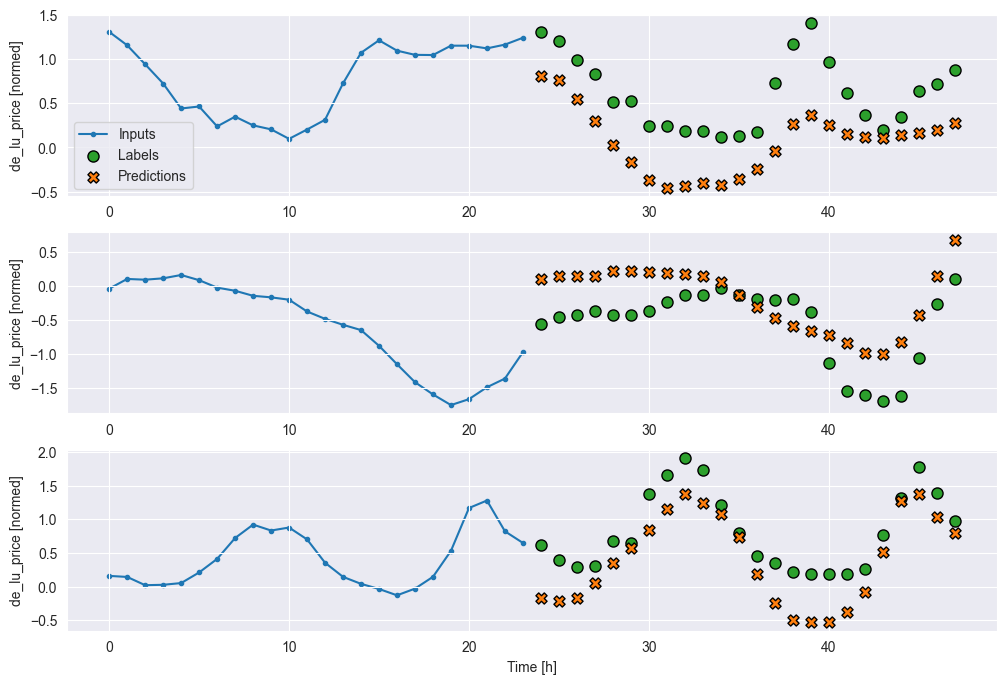

In [138]:
window.plot(lstm_model, "de_lu_price")

In [139]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [140]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7158 - mean_absolute_percentage_error: 348.4152 - val_loss: 406384672.0000 - val_mean_absolute_percentage_error: 904480.3750
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3820 - mean_absolute_percentage_error: 518.5080 - val_loss: 406379712.0000 - val_mean_absolute_percentage_error: 1171866.0000
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3019 - mean_absolute_percentage_error: 500.9108 - val_loss: 406380480.0000 - val_mean_absolute_percentage_error: 1040421.1875
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2733 - mean_absolute_percentage_error: 475.4673 - val_loss: 406376288.0000 - val_mean_absolute_percentage_error: 989972.9375
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2571 - mean_absolute_percentage_error: 491.5380 - val_loss: 406375360.0000 - val_mean_absolute_percentage_error: 1109883.3750
Epoch 6/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.

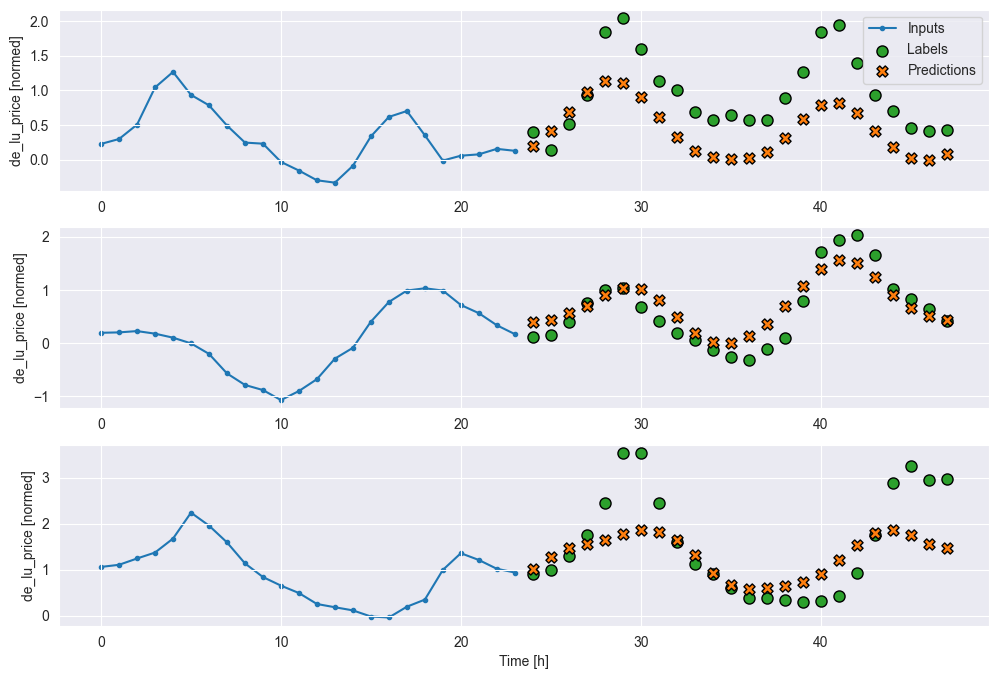

In [141]:
multi_window.plot(multi_lstm_model, "de_lu_price")